F-two Dual (that corresponds to F-Neon):

C:\TMP\ipykernel_9364\1480009319.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


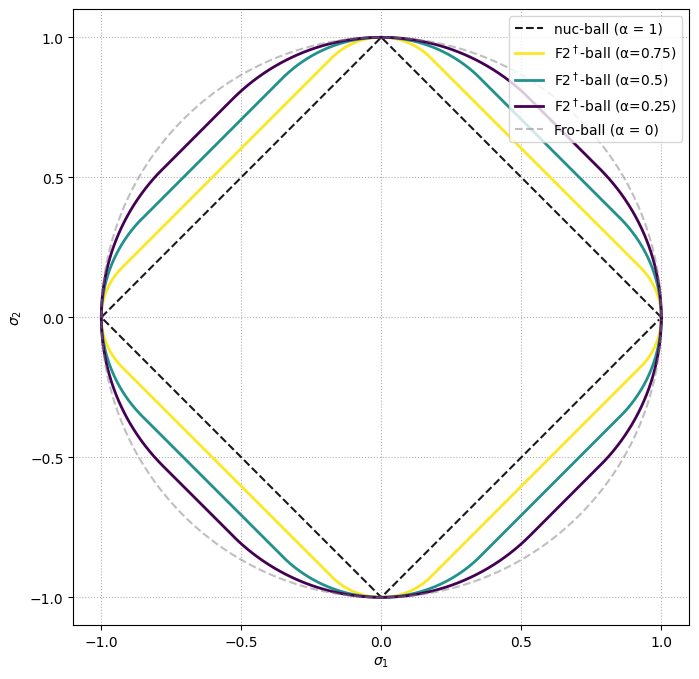

In [1]:
# for different alphas lmos for F-Neon
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def minkowski_sum_boundary_fneon(alpha, num_angles=2000):
    r1 = alpha            # L1-ball radius (diamond)
    r2 = 1.0 - alpha      # L2-ball radius (circle)
    thetas = np.linspace(0, 2*np.pi, num_angles, endpoint=False)
    pts = []
    for th in thetas:
        u = np.array([np.cos(th), np.sin(th)])  # direction
        
        # Support point on r2 * L2 ball is simply r2 * u
        s2 = r2 * u
        
        # Support point on r1 * L1 ball:
        # pick the axis with larger |component|, place full mass there with the sign
        if abs(u[0]) >= abs(u[1]):
            s1 = np.array([r1 * np.sign(u[0]), 0.0])
        else:
            s1 = np.array([0.0, r1 * np.sign(u[1])])
        
        pts.append(s1 + s2)
    return np.array(pts)

def l1_ball_boundary(radius, num=800):
    t = np.linspace(0, 2*np.pi, num, endpoint=False)
    x = np.cos(t)
    y = np.sin(t)
    denom = np.maximum(np.abs(x) + np.abs(y), 1e-12)
    return radius * x / denom, radius * y / denom

def l2_ball_boundary(radius, num=800):
    t = np.linspace(0, 2*np.pi, num, endpoint=False)
    return radius * np.cos(t), radius * np.sin(t)

# List of alpha values to test
alphas = [0.75, 0.5, 0.25]
colormap = cm.get_cmap('viridis')
colors = [colormap(i / (len(alphas) - 1)) for i in range(len(alphas) - 1, -1, -1)]
# Plot
plt.figure(figsize=(8, 8))
# Plot reference L1 and L2 balls
x1, y1 = l1_ball_boundary(1)
x2, y2 = l2_ball_boundary(1)
plt.plot(x1, y1, linestyle="--", label="nuc-ball (α = 1)", color="black", alpha=0.9)

# Plot Minkowski sums for each alpha
for alpha, color in zip(alphas, colors):
    sum_pts = minkowski_sum_boundary_fneon(alpha)
    plt.plot(sum_pts[:, 0], sum_pts[:, 1], label=f"F2$^\dagger$-ball (α={alpha})", 
             linewidth=2, color=color)

plt.plot(x2, y2, linestyle="--", label="Fro-ball (α = 0)", color="gray", alpha=0.5)

# Configure plot
plt.gca().set_aspect("equal", adjustable="box")
# plt.title("Minkowski sums: α L1-ball ⊕ (1-α) L2-ball for different α")
plt.xlabel("$\sigma_1$")
plt.ylabel("$\sigma_2$")
plt.legend(loc="upper right")
plt.grid(True, linestyle=":")
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.yticks(np.arange(-1, 1.1, 0.5))
plt.savefig("ftwodualball.pdf", dpi=300, bbox_inches='tight')
plt.show()


C:\TMP\ipykernel_9364\1003182011.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


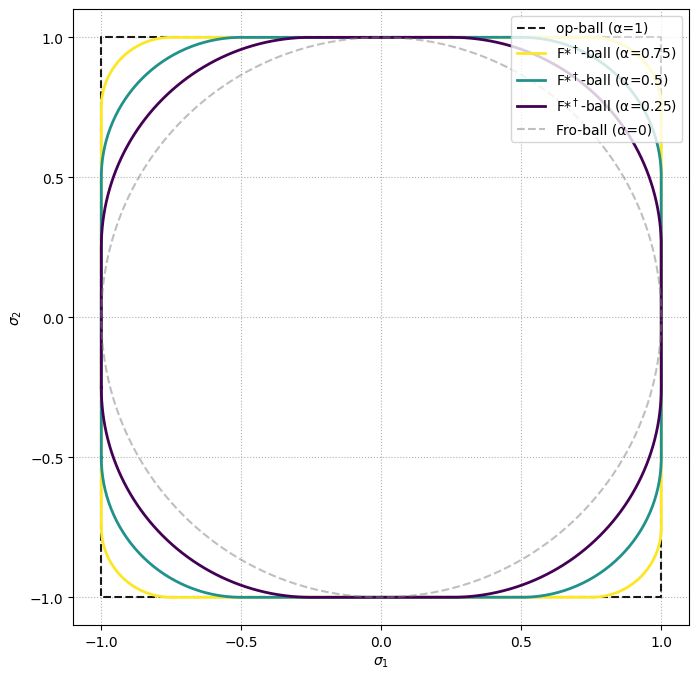

In [2]:
# different alphas lmos for F-Neon
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.spatial import ConvexHull

def minkowski_sum_boundary_fmuon(alpha, n_edge=200, n_circle=400):
    """
    Return the boundary points of alpha * B_inf(1) + (1 - alpha) * B_2(1) in 2D.
    Robust handling for alpha close to 0 or 1.
    """
    alpha = float(alpha)
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("alpha must be in [0, 1]")
    
    eps = 1e-12
    if alpha <= eps:
        # Pure circle
        theta = np.linspace(0, 2*np.pi, n_circle, endpoint=False)
        circle = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        boundary = np.vstack([circle, circle[0]])
        return boundary

    if alpha >= 1 - eps:
        # Pure square (sample full edges)
        t = np.linspace(-1, 1, n_edge)
        right  = np.stack([np.ones_like(t), t], axis=1)
        top    = np.stack([t[::-1], np.ones_like(t)], axis=1)
        left   = np.stack([-np.ones_like(t), t[::-1]], axis=1)
        bottom = np.stack([t, -np.ones_like(t)], axis=1)
        square = np.vstack([right, top, left, bottom])
        boundary = np.vstack([square, square[0]])
        return boundary

    # --- General case: sample both boundaries and compute convex hull ---
    t = np.linspace(-1, 1, n_edge)
    right  = np.stack([np.ones_like(t), t], axis=1)
    top    = np.stack([t[::-1], np.ones_like(t)], axis=1)
    left   = np.stack([-np.ones_like(t), t[::-1]], axis=1)
    bottom = np.stack([t, -np.ones_like(t)], axis=1)
    square = np.vstack([right, top, left, bottom])
    
    theta = np.linspace(0, 2*np.pi, n_circle, endpoint=False)
    circle = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    
    S = (alpha * square[:, None, :] + (1 - alpha) * circle[None, :, :]).reshape(-1, 2)
    
    S_rounded = np.round(S, decimals=12)
    S_unique = np.unique(S_rounded, axis=0)
    
    hull = ConvexHull(S_unique)
    boundary = S_unique[hull.vertices]
    
    centroid = boundary.mean(axis=0)
    angles = np.arctan2(boundary[:,1] - centroid[1], boundary[:,0] - centroid[0])
    order = np.argsort(angles)
    boundary = boundary[order]
    
    if not np.allclose(boundary[0], boundary[-1]):
        boundary = np.vstack([boundary, boundary[0]])
    
    return boundary



def linfty_ball_boundary(radius, num=800):
    # Parametrize the L∞ "circle" (square) using angle and normalization
    t = np.linspace(0, 2*np.pi, num, endpoint=False)
    x = np.cos(t)
    y = np.sin(t)
    # Compute the maximum of |x| and |y| element-wise, then ensure no division by zero
    denom = np.maximum(np.abs(x), np.abs(y))
    denom = np.maximum(denom, 1e-12)  # Avoid division by zero
    return radius * x / denom, radius * y / denom


# List of alpha values to test
alphas = [0.75, 0.5, 0.25]
# Use viridis colormap for nicer color gradient
colormap = cm.get_cmap('viridis')
colors = [colormap(i / (len(alphas) - 1)) for i in range(len(alphas) - 1, -1, -1)]

# Plot
plt.figure(figsize=(8, 8))

# Plot reference L∞ and L2 balls
x1, y1 = linfty_ball_boundary(1)
x2, y2 = l2_ball_boundary(1)
plt.plot(x1, y1, linestyle="--", label="op-ball (α=1)", color="black", alpha=0.9)

# Plot Minkowski sums for each alpha
for alpha, color in zip(alphas, colors):
    sum_pts = minkowski_sum_boundary_fmuon(alpha)
    plt.plot(sum_pts[:, 0], sum_pts[:, 1], label=f"F*$^\dagger$-ball (α={alpha})", 
             linewidth=2, color=color)

plt.plot(x2, y2, linestyle="--", label="Fro-ball (α=0)", color="gray", alpha=0.5)

# Configure plot
plt.gca().set_aspect("equal", adjustable="box")
# plt.title("Minkowski sums: α L∞-ball ⊕ (1-α) L2-ball for different α")
plt.xlabel("$\sigma_1$")
plt.ylabel("$\sigma_2$")
plt.legend(loc="upper right")
plt.grid(True, linestyle=":")
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.yticks(np.arange(-1, 1.1, 0.5))
plt.savefig("fstardualball.pdf", dpi=300, bbox_inches='tight')
plt.show()

CIFAR-10 Norms comparison:

C:\TMP\ipykernel_9364\2803006253.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


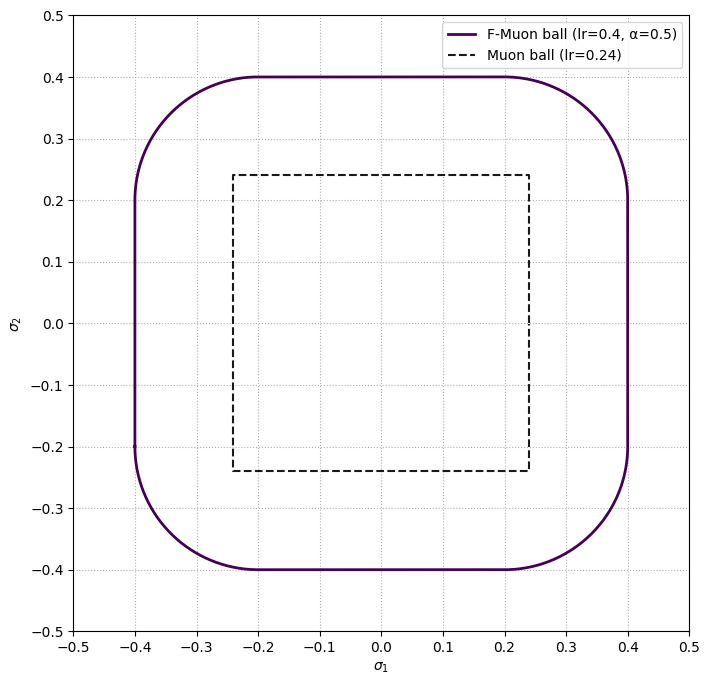

In [3]:
# the code plots F-Muon and Muon optimal lmo balls for CIFAR airbench
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull


# List of alpha values to test
alphas = [0.5]
colormap = cm.get_cmap('viridis')
colors = [colormap(i / (len(alphas))) for i in range(len(alphas) - 1, -1, -1)]
# Plot
plt.figure(figsize=(8, 8))

# Plot Minkowski sums for each alpha
for alpha, color in zip(alphas, colors):
    sum_pts = 0.4 * minkowski_sum_boundary_fmuon(alpha) # 0.4 is for F-Muon lr, which is \eta in lmo
    plt.plot(sum_pts[:, 0], sum_pts[:, 1], label=f"F-Muon ball (lr=0.4, α={alpha})", 
             linewidth=2, color=color)

# Plot reference L1 and L2 balls
x1, y1 = linfty_ball_boundary(0.24) # 0.24 is for Muon lr
plt.plot(x1, y1, linestyle="--", label="Muon ball (lr=0.24)", color="black", alpha=0.9)

# Configure plot
plt.gca().set_aspect("equal", adjustable="box")
# plt.title("Minkowski sums: α L1-ball ⊕ (1-α) L2-ball for different α")
plt.xlabel("$\sigma_1$")
plt.ylabel("$\sigma_2$")
plt.legend(loc="upper right")
plt.grid(True, linestyle=":")
plt.xticks(np.arange(-0.5, 0.55, 0.1))
plt.yticks(np.arange(-0.5, 0.55, 0.1))
plt.savefig("fstardual_cifar.pdf", dpi=300, bbox_inches='tight')
plt.show()


C:\TMP\ipykernel_9364\3178439146.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


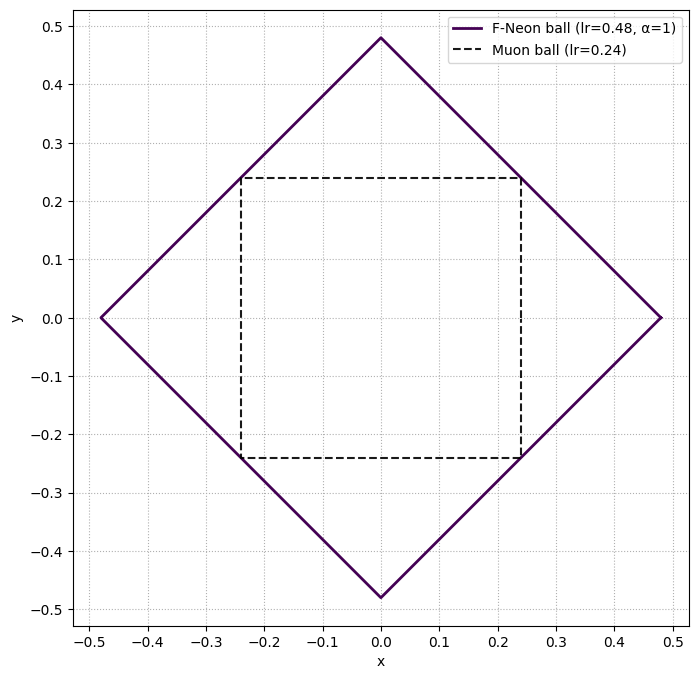

In [4]:
# the code plots F-Muon and Muon optimal lmo balls for CIFAR airbench
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull


# List of alpha values to test
alphas = [1]
colormap = cm.get_cmap('viridis')
colors = [colormap(i / (len(alphas))) for i in range(len(alphas) - 1, -1, -1)]
# Plot
plt.figure(figsize=(8, 8))

# Plot Minkowski sums for each alpha
for alpha, color in zip(alphas, colors):
    fneon_lr = 0.48
    sum_pts = fneon_lr * minkowski_sum_boundary_fneon(alpha) # 0.4 is for F-Muon lr, which is \eta in lmo
    plt.plot(sum_pts[:, 0], sum_pts[:, 1], label=f"F-Neon ball (lr={fneon_lr}, α={alpha})", 
             linewidth=2, color=color)

# Plot reference L1 and L2 balls
x1, y1 = linfty_ball_boundary(0.24) # 0.24 is for Muon lr
plt.plot(x1, y1, linestyle="--", label="Muon ball (lr=0.24)", color="black", alpha=0.9)

# Configure plot
plt.gca().set_aspect("equal", adjustable="box")
# plt.title("Minkowski sums: α L1-ball ⊕ (1-α) L2-ball for different α")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper right")
plt.grid(True, linestyle=":")
plt.xticks(np.arange(-0.5, 0.55, 0.1))
plt.yticks(np.arange(-0.5, 0.55, 0.1))
# plt.savefig("fstardual_cifar.pdf", dpi=300, bbox_inches='tight')
plt.show()


NanoGPT:

C:\TMP\ipykernel_9364\3045285299.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


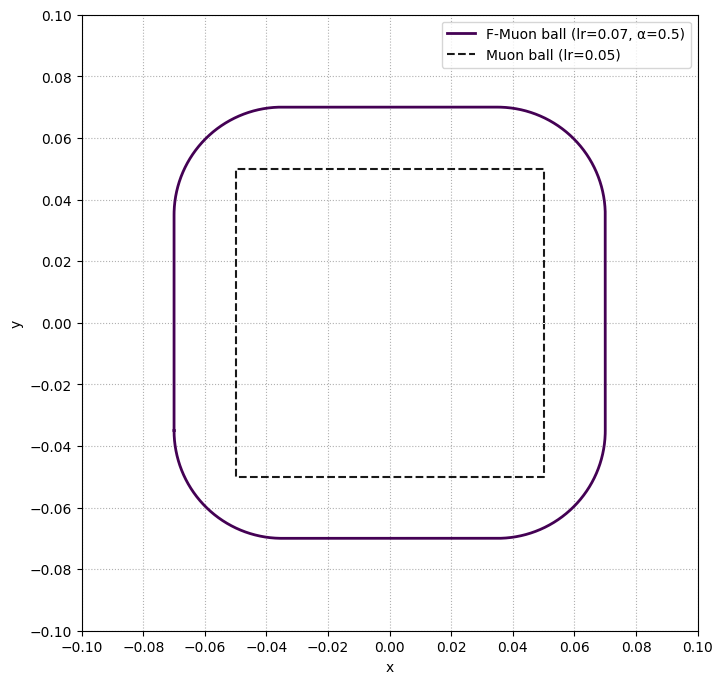

In [5]:
alphas = [0.5]
colormap = cm.get_cmap('viridis')
colors = [colormap(i / (len(alphas))) for i in range(len(alphas) - 1, -1, -1)]
# Plot
plt.figure(figsize=(8, 8))

# Plot Minkowski sums for each alpha
for alpha, color in zip(alphas, colors):
    sum_pts = 0.07 * minkowski_sum_boundary_fmuon(alpha) # 0.4 is for F-Muon lr, which is \eta in lmo
    plt.plot(sum_pts[:, 0], sum_pts[:, 1], label=f"F-Muon ball (lr=0.07, α={alpha})", 
             linewidth=2, color=color)

# Plot reference L1 and L2 balls
x1, y1 = linfty_ball_boundary(0.05) # 0.24 is for Muon lr
plt.plot(x1, y1, linestyle="--", label="Muon ball (lr=0.05)", color="black", alpha=0.9)

# Configure plot
plt.gca().set_aspect("equal", adjustable="box")
# plt.title("Minkowski sums: α L1-ball ⊕ (1-α) L2-ball for different α")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper right")
plt.grid(True, linestyle=":")
plt.xticks(np.arange(-0.1, 0.12, 0.02))
plt.yticks(np.arange(-0.1, 0.12, 0.02))
plt.savefig("fstardual_nanogpt.pdf", dpi=300, bbox_inches='tight')
plt.show()


Case when $\alpha > 1$ for F-Muon: 

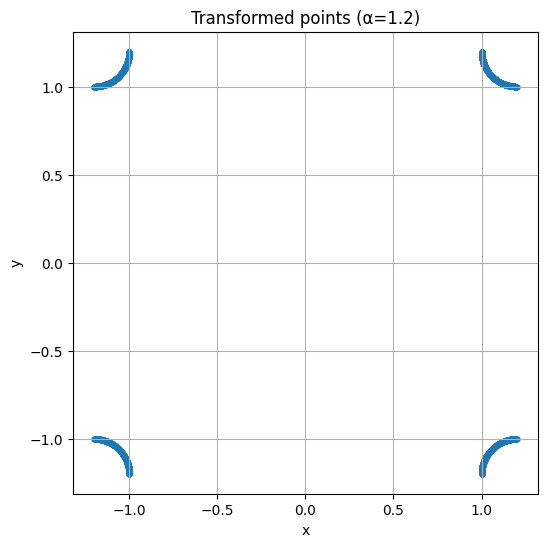

In [6]:
# Parameters
alpha = 1.2
num_points = 5000
dim = 2

# Generate random unit vectors in 2D
v = np.random.randn(num_points, dim)
v /= np.linalg.norm(v, axis=1, keepdims=True)

# Compute the transformed points
sign_v = np.sign(v)
p = alpha * sign_v - (alpha - 1) * v

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(p[:, 0], p[:, 1], s=10, alpha=0.6)
plt.title(f"Transformed points (α={alpha})")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

F-Neon:

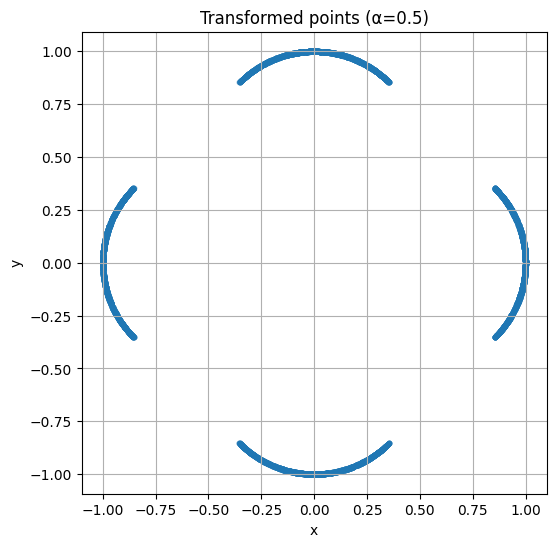

In [7]:
# Parameters
alpha = 0.5
num_points = 5000
dim = 2

# Generate random unit vectors in 2D
v = np.random.randn(num_points, dim)
v /= np.linalg.norm(v, axis=1, keepdims=True)

# Compute the transformed points
def greedy_sign(v):
    """Return sign only along the coordinate(s) with the largest absolute value."""
    s = np.zeros_like(v)
    abs_v = np.abs(v)
    max_mask = abs_v == abs_v.max(axis=1, keepdims=True)
    s[max_mask] = np.sign(v[max_mask])
    return s
sign_v = greedy_sign(v)

p = alpha * sign_v - (alpha - 1) * v

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(p[:, 0], p[:, 1], s=10, alpha=0.6)
plt.title(f"Transformed points (α={alpha})")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

Muon-Neon:

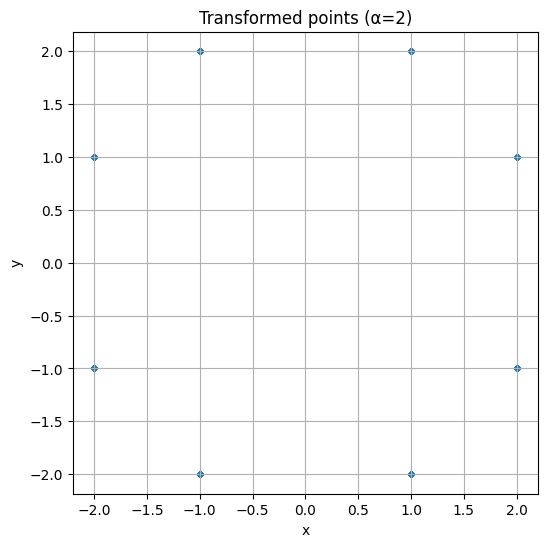

In [8]:
# Parameters
alpha = 2
num_points = 5000
dim = 2

# Generate random unit vectors in 2D
v = np.random.randn(num_points, dim)
v /= np.linalg.norm(v, axis=1, keepdims=True)

# Compute the transformed points
def greedy_sign(v):
    """Return sign only along the coordinate(s) with the largest absolute value."""
    s = np.zeros_like(v)
    abs_v = np.abs(v)
    max_mask = abs_v == abs_v.max(axis=1, keepdims=True)
    s[max_mask] = np.sign(v[max_mask])
    return s
greedy_sign_v = greedy_sign(v)

p = alpha * np.sign(v) - (alpha - 1) * greedy_sign_v

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(p[:, 0], p[:, 1], s=10, alpha=0.6)
plt.title(f"Transformed points (α={alpha})")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

F-Muon with nuclear NSGD:

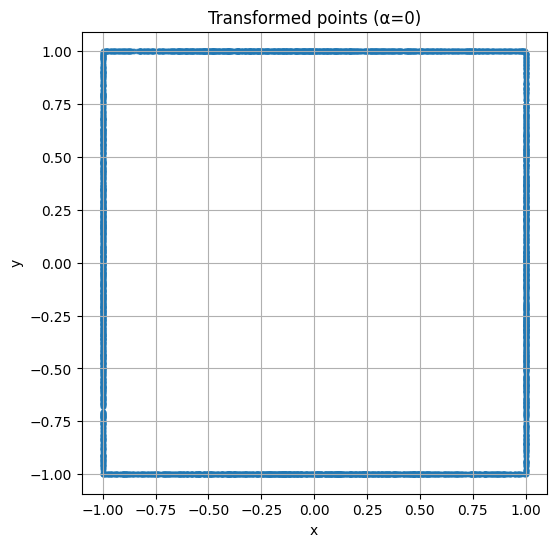

In [9]:
# Parameters
alpha = 0
num_points = 5000
dim = 2

# Generate random unit vectors in 2D
v = np.random.randn(num_points, dim)
v /= np.linalg.norm(v, axis=1, keepdims=True)

# Compute the transformed points
sign_v = np.sign(v)
p = alpha * sign_v - (alpha - 1) * v / np.linalg.norm(v, axis=1, keepdims=True, ord=np.inf)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(p[:, 0], p[:, 1], s=10, alpha=0.6)
plt.title(f"Transformed points (α={alpha})")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()